In [1]:
# %pip install transformer_lens circuitsvis

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [3]:
def imshow(tensor, model=None, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).write_image('images/' + model + '/' + kwargs.get('title') + '.png')

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [4]:
import numpy as np
from einops import repeat
import circuitsvis as cv

n = 1000
m = 10

gcd_targets = np.random.randint(1, 65, size=n)
gcd_targets_expanded = repeat(gcd_targets, 'n -> (n m)', m=m)
scaling_factors = np.random.randint(1, 256 // gcd_targets_expanded[:, None], size=(n * m, 3))

numbers = gcd_targets_expanded[:, None] * scaling_factors
numbers_grouped = numbers.reshape(n, m, 3)

for i, target_gcd in enumerate(gcd_targets[:2]):
    print(f"\nTarget GCD: {target_gcd}")
    print("Triplets:")
    print(numbers_grouped[i])


Target GCD: 45
Triplets:
[[180 180 135]
 [180 180 135]
 [ 45  90  90]
 [ 45 135 180]
 [180  90  90]
 [ 90 180  45]
 [ 45 135 135]
 [ 45  45  45]
 [ 45 180  45]
 [ 45  90 180]]

Target GCD: 43
Triplets:
[[129 172  43]
 [ 43 129 172]
 [129  86 172]
 [172 172 129]
 [129 129 172]
 [129  43 172]
 [129  86 172]
 [ 43 172  86]
 [ 86 172 129]
 [172  43 172]]


In [5]:
numbers_tensor = torch.tensor(numbers, dtype=int)
gcd_tensor = torch.tensor(gcd_targets_expanded, dtype=int).reshape(10000, 1)
numbers_tensor.shape, gcd_tensor.shape

(torch.Size([10000, 3]), torch.Size([10000, 1]))

In [6]:
concatenated_tensor = torch.cat((numbers_tensor, gcd_tensor), dim=1)
concatenated_tensor.shape

torch.Size([10000, 4])

In [7]:
sample_indices = np.random.choice(concatenated_tensor.shape[0], size=5, replace=False)
samples = concatenated_tensor[sample_indices]
samples

tensor([[ 42,  98,   7,   7],
        [ 58,  87,  58,  29],
        [200, 140,  80,  20],
        [184,  92, 184,  46],
        [177, 118,  59,  59]])

In [8]:
training_datapoints = []
for _ in range(2000):
  sample_indices = np.random.choice(concatenated_tensor.shape[0], size=10, replace=False)
  samples = concatenated_tensor[sample_indices]
  prompt = ''
  for idx, tensor in enumerate(samples):
    prompt += (','.join(map(str, (tensor[:-1].tolist()))) + f'=>{tensor[-1]}\n')
  training_datapoints.append(prompt.strip())

test_datapoints = []
for _ in range(1000):
  sample_indices = np.random.choice(concatenated_tensor.shape[0], size=10, replace=False)
  samples = concatenated_tensor[sample_indices]
  prompt = ''
  for idx, tensor in enumerate(samples):
    prompt += (','.join(map(str, (tensor[:-1].tolist()))) + f'=>{tensor[-1]}\n')
  test_datapoints.append(prompt.strip())

In [9]:
print(training_datapoints[0])

24,72,120=>24
153,204,102=>51
132,132,176=>44
224,196,28=>28
143,55,231=>11
172,43,129=>43
186,217,186=>31
170,204,68=>17
27,189,162=>27
61,122,183=>61


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_theme(rc={'figure.figsize':(5,5)})

In [11]:
from transformer_lens import evals

model_names = ['attn-only-1l','attn-only-2l','attn-only-3l']

In [12]:
MODEL='solu-2l'
model = HookedTransformer.from_pretrained(MODEL, device=device)
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False
model

Loaded pretrained model solu-2l into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_mid): HookPoint()
        (ln): LayerNormPre(
          (hook_scale): HookPoint()
          (hook_normalized): HookPoint()
        )
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()

In [13]:
for name, params in model.named_parameters():
  print(name, params.shape)

embed.W_E torch.Size([48262, 512])
pos_embed.W_pos torch.Size([1024, 512])
blocks.0.attn.W_Q torch.Size([8, 512, 64])
blocks.0.attn.W_O torch.Size([8, 64, 512])
blocks.0.attn.b_Q torch.Size([8, 64])
blocks.0.attn.b_O torch.Size([512])
blocks.0.attn.W_K torch.Size([8, 512, 64])
blocks.0.attn.W_V torch.Size([8, 512, 64])
blocks.0.attn.b_K torch.Size([8, 64])
blocks.0.attn.b_V torch.Size([8, 64])
blocks.0.mlp.W_in torch.Size([512, 2048])
blocks.0.mlp.b_in torch.Size([2048])
blocks.0.mlp.W_out torch.Size([2048, 512])
blocks.0.mlp.b_out torch.Size([512])
blocks.1.attn.W_Q torch.Size([8, 512, 64])
blocks.1.attn.W_O torch.Size([8, 64, 512])
blocks.1.attn.b_Q torch.Size([8, 64])
blocks.1.attn.b_O torch.Size([512])
blocks.1.attn.W_K torch.Size([8, 512, 64])
blocks.1.attn.W_V torch.Size([8, 512, 64])
blocks.1.attn.b_K torch.Size([8, 64])
blocks.1.attn.b_V torch.Size([8, 64])
blocks.1.mlp.W_in torch.Size([512, 2048])
blocks.1.mlp.b_in torch.Size([2048])
blocks.1.mlp.W_out torch.Size([2048, 512])


In [14]:
from torch.utils.data import Dataset, DataLoader

class GCDDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {"tokens": self.data[idx]}

tokenized_training_datapoints = model.to_tokens(training_datapoints, prepend_bos=False)
tokenized_test_datapoints = model.to_tokens(test_datapoints, prepend_bos=False)

train_dataset = GCDDataset(tokenized_training_datapoints)
test_dataset = GCDDataset(tokenized_test_datapoints)

In [15]:
import json
from tqdm.autonotebook import tqdm

total_steps = 500

def train(
    model,
    config
):
    torch.manual_seed(config.seed)
    model.train()
    if config.wandb:
        if config.wandb_project_name is None:
            config.wandb_project_name = "easy-transformer"
        # wandb.init(project=config.wandb_project_name, config=vars(config))

    if config.device is None:
        config.device = utils.get_device()

    if config.optimizer_name in ["Adam", "AdamW"]:
        if config.weight_decay is not None:
            optimizer = optim.AdamW(
                model.parameters(),
                lr=config.lr,
                weight_decay=config.weight_decay,
            )
        else:
            optimizer = optim.Adam(
                model.parameters(),
                lr=config.lr,
            )
    elif config.optimizer_name == "SGD":
        optimizer = optim.SGD(
            model.parameters(),
            lr=config.lr,
            weight_decay=(config.weight_decay if config.weight_decay is not None else 0.0),
            momentum=config.momentum,
        )
    else:
        raise ValueError(f"Optimizer {config.optimizer_name} not supported")

    scheduler = None
    if config.warmup_steps > 0:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: min(1.0, step / config.warmup_steps),
        )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

    model.to(config.device)

    steps = 0
    step_stats = []
    train_losses = []
    test_losses = []
    per_token_losses = []
    for epoch in tqdm(range(1, config.num_epochs + 1)):
        if config.max_steps is not None and steps >= config.max_steps:
            break

        pbar = tqdm(zip(train_loader, test_loader))
        for batch_train, batch_test in pbar:
            steps += 1

            if steps > config.max_steps:
                return model, train_losses, test_losses, per_token_losses

            model.train()
            tokens = batch_train['tokens'].to(config.device)
            loss = model(tokens, return_type="loss", prepend_bos=False)
            optimizer.zero_grad()
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()
            if config.warmup_steps > 0:
                assert scheduler is not None
                scheduler.step()
            model.eval()
            test_tokens = batch_test['tokens'].to(config.device)
            test_logits = model(tokens, return_type="logits", prepend_bos=False)
            per_token_loss = utils.lm_cross_entropy_loss(test_logits, test_tokens, per_token=True).detach()
            icl_score = (per_token_loss[:, -1]-per_token_loss[:, 0]).mean()
            test_losses.append(icl_score.item())
            per_token_losses.append(per_token_loss)

            pbar.set_postfix({"train_loss": loss.item(), "icl_score": icl_score.item(), 'steps': steps})
            step_stats.append({"train_loss": loss.item(), "icl_score": icl_score.item(), 'steps': steps})
            # wandb.log({"train_loss": loss.item(), "icl_score": icl_score.item()})

            if (
                config.save_every is not None
                and steps % config.save_every == 0
                and config.save_dir is not None
            ):
                torch.save(model.state_dict(), f"{config.save_dir}/model_checkpoint_{steps}.pth")

            if config.max_steps is not None and steps >= config.max_steps:
                break

    with open('log_' + MODEL + '.json', 'a') as f:
        json.dump(step_stats, f)
    return model, train_losses, test_losses, per_token_losses

In [16]:
from transformer_lens.train import HookedTransformerTrainConfig

!rm -r checkpoints/{MODEL}
!mkdir -p checkpoints/{MODEL}
!rm log_{MODEL}.json

model, train_losses, test_losses, per_token_losses = train(model, config=HookedTransformerTrainConfig(device=device, num_epochs=100, batch_size=32, lr=1e-4, wandb=True, wandb_project_name=MODEL, save_every=100, save_dir='checkpoints/' + MODEL, max_steps=total_steps))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


rm: cannot remove 'log_solu-2l.json': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Moving model to device:  cuda:1


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

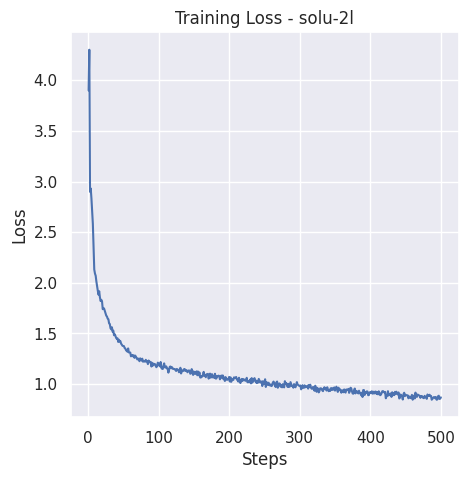

In [17]:
plt.title("Training Loss - " + MODEL)
plt.xlabel("Steps")
plt.ylabel("Loss")
sns.lineplot(x=range(1,500+1), y=train_losses[:500])
plt.show()


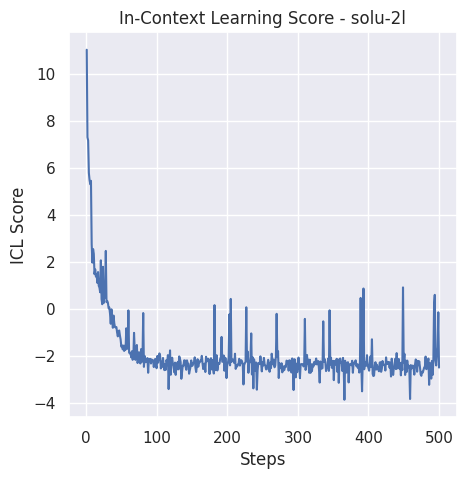

In [18]:
plt.title("In-Context Learning Score - " + MODEL)
plt.xlabel("Steps")
plt.ylabel("ICL Score")
sns.lineplot(x=range(1,500+1), y=test_losses[:500])
plt.show()

In [19]:
tokens = model.to_tokens(test_datapoints[-50].split('\n')[0], prepend_bos=False)
original_logits, cache = model.run_with_cache(tokens)
print(original_logits.numel())

627406


In [20]:
for param_name, param in cache.items():
    print(param_name, param.shape)

hook_embed torch.Size([1, 13, 512])
hook_pos_embed torch.Size([1, 13, 512])
blocks.0.hook_resid_pre torch.Size([1, 13, 512])
blocks.0.ln1.hook_scale torch.Size([1, 13, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 13, 512])
blocks.0.attn.hook_q torch.Size([1, 13, 8, 64])
blocks.0.attn.hook_k torch.Size([1, 13, 8, 64])
blocks.0.attn.hook_v torch.Size([1, 13, 8, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 8, 13, 13])
blocks.0.attn.hook_pattern torch.Size([1, 8, 13, 13])
blocks.0.attn.hook_z torch.Size([1, 13, 8, 64])
blocks.0.hook_attn_out torch.Size([1, 13, 512])
blocks.0.hook_resid_mid torch.Size([1, 13, 512])
blocks.0.ln2.hook_scale torch.Size([1, 13, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 13, 512])
blocks.0.mlp.hook_pre torch.Size([1, 13, 2048])
blocks.0.mlp.hook_mid torch.Size([1, 13, 2048])
blocks.0.mlp.ln.hook_scale torch.Size([1, 13, 1])
blocks.0.mlp.ln.hook_normalized torch.Size([1, 13, 2048])
blocks.0.mlp.hook_post torch.Size([1, 13, 2048])
blocks.0.hook_mlp_o

In [21]:
# %pip install kaleido
!mkdir -p images/{MODEL}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
for l in [0,1]:
  imshow(cache["pattern", l].mean(dim=0)[:, -1, :], model=MODEL, title=f"Average Attention Pattern per Head - Layer {l}", xaxis="Token Index", yaxis="Head")

In [23]:
for l in range(0, 2):
  for i in range(0, model.cfg.n_heads):
    imshow(cache["pattern", l][:, i].reshape(cache["pattern", l].shape[2], cache["pattern", l].shape[2]), model=MODEL, title=f"Attention for Head {i}, Layer {l}")

In [24]:

tokens = model.to_tokens(test_datapoints[-50].split('\n')[0], prepend_bos=False)
original_logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)
str_tokens = model.to_str_tokens(test_datapoints[-50].split('\n')[0], prepend_bos=False)
for l in range(model.cfg.n_layers):
  print('Layer ' + str(l))
  attention_pattern = cache["pattern", l, "attn"]
  display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))

Layer 0


Layer 1


In [26]:
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
tokens = model.to_tokens(test_datapoints[-50].split('\n')[0], prepend_bos=False)
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern,
    hook,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

model.run_with_hooks(
    tokens, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, model=MODEL, xaxis="Head", yaxis="Layer", title="Induction Score by Head")

In [27]:
neuron_activations_for_all_layers = torch.stack([
    cache["post", layer, "mlp"] for layer in range(model.cfg.n_layers)
], dim=1)


cv.activations.text_neuron_activations(
    tokens=str_tokens,
    activations=neuron_activations_for_all_layers
)

In [29]:
def induction_attn_detector(cache) -> list[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be induction heads

    Remember - the tokens used to generate rep_cache are (bos_token, *rand_tokens, *rand_tokens)
    '''
    # SOLUTION
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            # take avg of (-seq_len+1)-offset elements
            seq_len = (attention_pattern.shape[-1] - 1) // 2
            score = attention_pattern.diagonal(-seq_len+1).mean()
            print(score)
            if score > 0.15:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads

induction_attn_detector(cache)

tensor(0.0433, device='cuda:1')
tensor(0.0909, device='cuda:1')
tensor(0.0090, device='cuda:1')
tensor(0.1285, device='cuda:1')
tensor(0.1347, device='cuda:1')
tensor(0.0034, device='cuda:1')
tensor(0.1032, device='cuda:1')
tensor(0.1248, device='cuda:1')
tensor(0.0343, device='cuda:1')
tensor(0.0143, device='cuda:1')
tensor(0.0469, device='cuda:1')
tensor(0.1542, device='cuda:1')
tensor(0.0721, device='cuda:1')
tensor(0.0518, device='cuda:1')
tensor(0.0363, device='cuda:1')
tensor(0.0315, device='cuda:1')


['1.3']

In [30]:
text = test_datapoints[-50]

cv.logits.token_log_probs(
    model.to_tokens(text, prepend_bos=True)[0].view(-1),
    model(text)[0].log_softmax(dim=-1),
    model.to_string,
)

In [ ]:
!zip -r trainingdynamics.zip . -x "*.pth"